In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
import sys, os
sys.path.append(os.path.abspath("/xdisk/sylvia/tropic_vis/utilities/"))
from plotting_utilities import stdev_bubble
from densityPlot import centroids
from calc_water import calc_water
import matplotlib.pyplot as plt

# Calculate trajectory lifetimes

In [77]:
# Trajectory duration for both longwave and shortwave heating scalings
bd = '/xdisk/sylvia/traj_output/'
file0 = xr.open_dataset( bd + 'ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter.nc' ) #'_iwc'
file1 = xr.open_dataset( bd + 'CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc.nc' )
file2 = xr.open_dataset( bd + 'ICON_0V2M0A0R_tst00000450_trim_extract_dt_filter.nc' )
file3 = xr.open_dataset( bd + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc.nc' )

fichiers = [ file0, file1, file2, file3 ]

bd2 = '/xdisk/sylvia/tropic_vis/output/'
ofichiers = [ bd2 + 'ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter_lifetimes_all2.npy',
              bd2 + 'CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc_filter_lifetimes_all2.npy',
              bd2 + 'ICON_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all2.npy',
              bd2 + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all2.npy' ]

In [97]:
T = file0['T']
IWC = file0['qi']

# Replace all your nan values with 10^(-8)
IWC = IWC.fillna( 10**(-8) )

# Find the arguments where qi > 10^(-8) and T < 237 K, i.e. non-negligible cirrus formation
IWC_masked = IWC.where( (IWC > 10**(-5)) & (T < 237), np.nan, 0 )

In [ ]:
# Calculate lifetime only from the longest sequence at cirrus temperatures
lifetimes = np.ndarray( (IWC.shape[1],) )
for i in np.arange(IWC.shape[1]):
    if i!=0 & i%100 == 0:
        print(i)
        print('Longest trajectory duration: ' + str((stop-start)*24/3600.) + ' hours')
    tr = IWC_masked[:,i] # Extract the trajectory of interest
    m = np.concatenate(( [True], np.isnan(tr), [True] ))  # Mask
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
    if ss.size == 0:
        continue
    else:
        start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
        lifetimes[i] = stop-start

In [98]:
# How many sequences (at all) per trajectory at cirrus temperatures?
nseq = np.ndarray( (IWC.shape[1],) )
for i in np.arange( IWC.shape[1] ):
    tr = IWC_masked[:,i] # Extract the trajectory of interest
    m = np.concatenate(( [True], np.isnan(tr), [True] ))  # Trues if tr is a NaN
    # In Python a nonzero integer value is True
    ss = np.flatnonzero(m[1:] != m[:-1])
    nseq[i] = len(ss)
    
for i in np.arange(0, 20, 2):
    j = np.argwhere(nseq == i)
    print(len(j)/len(nseq)*100.)

42.45647483819176
0.11038081380763634
0.12543274296322313
0.336159751141438
0.5117655912899503
0.797752245246099
1.1690331644172394
1.7259545431739503
2.7043299382870907
3.4167879183181973


In [106]:
# How many sequences (that qualify as clouds) per trajectory at cirrus temperatures?
nseq = np.ndarray( (IWC.shape[1],) )
for i in np.arange( IWC.shape[1] ):
    tr = IWC_masked[:,i] # Extract the trajectory of interest
    m = np.concatenate(( [True], np.isnan(tr), [True] ))  # Trues if tr is a NaN
    # In Python a nonzero integer value is True
    ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2) 
    
    ss2 = []
    for k, s in enumerate(ss[:-1]):
        if (ss[k,1]-ss[k,0] >= 150) & (ss[k+1,0]-ss[k,1] >= 75):
            ss2.append( list(ss[k]) )
    ss2 = np.array( ss2 ) 
    nseq[i] = len(ss2)

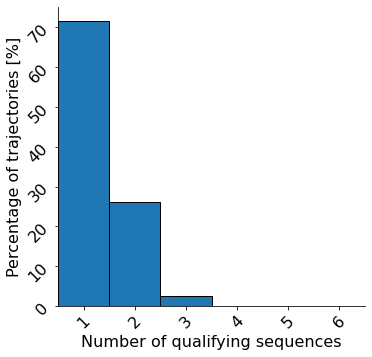

In [107]:
fig = plt.figure( figsize=(5.5, 5.5) )
ax = plt.gca()
ax.hist( x=nseq/2.0, bins=np.linspace(0, 6, 7), weights=np.ones_like(nseq)/len(nseq)*100., edgecolor='k' )
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlim( [0, 6] )
ax.set_xticks( [0.5, 1.5, 2.5, 3.5, 4.5, 5.5] )
ax.set_xticklabels( [1, 2, 3, 4, 5, 6] )
ax.tick_params( axis='both', labelsize=16, rotation=45 )
ax.set_ylabel( 'Percentage of trajectories [%]', fontsize=16 )
ax.set_xlabel( 'Number of qualifying sequences', fontsize=16 )
plt.savefig( '/xdisk/sylvia/tropic_vis/output/qualifying-sequence-distribution2.pdf', bbox_inches='tight' )

In [32]:
# What are ALL sequence lengths not just the longest?
lifetimes_all = []
for f, of in zip(fichiers, ofichiers):
    print(of)
    T = f['T']
    IWC = f['qi']

    # Replace all your nan values with 10^(-8)
    IWC = IWC.fillna( 10**(-8) )

    # Find the arguments where qi > 10^(-8) and T < 237 K, i.e. non-negligible cirrus formation
    IWC_masked = IWC.where( (IWC > 10**(-8)) & (T < 237), np.nan, 0 )
    lifetimes = np.ndarray( (IWC.shape[1],) )
    
    for i in np.arange(IWC.shape[1]):
        #if (i > 99) & (i % 100 == 0):
        #    print( i )
        tr = IWC_masked[:,i]  # Extract the trajectory of interest
        m = np.concatenate(( [True], np.isnan(tr), [True] ))  # Mask
        ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
        
        # Take only the maximum sequence as the lifetime
        #if ss.size == 0:
        #    continue
        #else:
        #    start, stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
        #lifetimes[i] = stop-start
        
        # Take all sequences of greater than a certain length and with more than a certain
        # separation from preceding sequences as the lifetime
        ss2 = []
        for k, s in enumerate(ss[:-1]):
            if (ss[k,1]-ss[k,0] >= 150) & (ss[k+1,0]-ss[k,1] >= 150):
                ss2.append( list(ss[k]) )
        ss2 = np.array( ss2 ) 
        if len(ss2) != 0:
            j = ss2[:,1] - ss2[:,0]
        lifetimes_all.extend( j )
        
    #print( np.nanmean(lifetimes_all)*24/3600 )
    print( np.nanmean(lifetimes_all)*24/3600 )
    #np.save( of, np.array(lifetimes_all) )

/xdisk/sylvia/traj_output/ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter_lifetimes_all2.npy
2.4550227568645075
/xdisk/sylvia/traj_output/CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc_filter_lifetimes_all2.npy
2.4413099494542663
/xdisk/sylvia/traj_output/ICON_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all2.npy
2.920632133398435
/xdisk/sylvia/traj_output/CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all2.npy
3.118380543343336


In [4]:
bd = '/xdisk/sylvia/tropic_vis/output/'
np.save( bd + 'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all.npy', np.array(lifetimes_all) )

In [13]:
lifetime1 = np.load( '/xdisk/sylvia/tropic_vis/output/ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter_lifetimes.npy' )
lifetime2 = np.load( '/xdisk/sylvia/tropic_vis/output/ICON_0V2M0A0R_tst00000450_trim_extract_dt_filter_lifetimes.npy' )
lifetime3 = np.load( '/xdisk/sylvia/tropic_vis/output/CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes.npy' )

#lifetime1 = np.load( '/xdisk/sylvia/tropic_vis/output/ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter_lifetimes_all.npy' )
#lifetime2 = np.load( '/xdisk/sylvia/tropic_vis/output/ICON_0V2M0A0R_tst00000450_trim_extract_dt_filter_lifetimes_all.npy' )
#lifetime3 = np.load( '/xdisk/sylvia/tropic_vis/output/CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter_lifetimes_all.npy' )

# Converting here from timesteps to hours
print( np.nanmean(lifetime1)*24/3600 )
print( np.nanmean(lifetime2)*24/3600 )
print( np.nanmean(lifetime3)*24/3600 )
#print( np.nanmean(np.array(lifetimes_all))*24/3600 )

3.0088943521816933
8.287202904494979
3.648867520393747


# Calculate temperature depth of trajectories and perform qi-T fitting within

In [4]:
# These thresholds are used throughout. Values below are considered negligible.
qi_threshold = 10**(-8)
Ni_threshold = 10**(-8)
RHi_threshold = 0

basedir = '/xdisk/sylvia/traj_output/'
fichiers = [ 'CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc_filter.nc', 'ICON_0V1M0A0R_tst00001350_trim_extract_dt_filter.nc',
             'CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter.nc', 'ICON_0V2M0A0R_tst00000450_trim_extract_dt_filter.nc' ]
RHi_1M0T1S = xr.open_dataset( basedir + fichiers[0] )['RHI']
RHi_2M1T1S = xr.open_dataset( basedir + fichiers[2] )['RHI']
RHi_fi = [ RHi_1M0T1S, RHi_1M0T1S, RHi_2M1T1S, RHi_2M1T1S ]

In [5]:
def quadratic_trend(x, y):
    z = np.polyfit(x, y, 2)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(z[0])

In [23]:
qiT_covariances = [ 19.994, -6.074, 16.576, -41.505 ]
iii = [0, 0, 1, 2]
iwp_array = np.zeros((3,))

for f, r, j, i in zip(fichiers, RHi_fi, np.arange(4), iii):
    fi = xr.open_dataset( basedir + f )
    
    histvals = 'qiTh_outflow'
    cov = qiT_covariances[j]
    ym, _, ys, xm, _, xs = centroids( histvals, j )
    Tmin, Tmax, _ = stdev_bubble( xm, ym, xs, ys, cov, n_std=0.5 )
    
    # Convert kg kg-1 to ppmv
    qi = fi['qi']
    T = fi['T']
    #if (j != 1) & (j != 3):
    #    P = fi['PE']
    #else:
    #    P = fi['p']
    #time = fi['time']
    #qi_ppmv = calc_water( T, P, qi )
    #qi_ppmv.name = 'qi_ppmv'
    ## Ensure that qi [kg kg-1] is not mistakenly used below
    #del qi
   
    # Filter for non-negligible qi (or now CLaMS RHi) values; side-note: large peak in ICON qi at 10**(-10)
    qi = qi.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    T = T.where( (r > RHi_threshold ) & (qi > qi_threshold) )
    
    # stack time and id into a single dimension called allpoints
    qi_outflow = qi.where( (T >= Tmin) & (T <= Tmax) ).stack(allpoints=['time','id'])
    T_outflow = T.where( (T >= Tmin) & (T <= Tmax) ).stack(allpoints=['time','id'])
    
    # omit nans
    idx = xr.ufuncs.isfinite( qi_outflow )
    
    # apply the function over allpoints to calculate the trend at each point
    #trend = stacked.groupby('allpoints').apply(quadratic_trend)
    z = np.polyfit( T_outflow[idx], qi_outflow[idx], 2 )
    
    # ice water path calculation from this polyfit
    T_arr = np.linspace( Tmin, Tmax, 100 )
    qi_arr = z[0]*T_arr**2 + z[1]*T_arr + z[2]
    #iwp = simps(qi_arr*10**(-6)/0.0055, T_arr ) # here in kg m-2
    iwp = 990/6.5*simps( qi_arr, T_arr ) # here in kg m-2
    if j != 1:
        iwp_array[i] = iwp
        print( 'IWP from ' + f + ' ' + str(iwp*1000) + ' g m-2' )

Tmin and Tmax: 227.2412029785002 229.6187970214998
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
IWP from CLAMS-Tf_0V1M0A0R_tst00001350_trim_extract_dt_iwc_filter.nc 5.546019422410722 g m-2
Tmin and Tmax: 228.7260316497871 230.75396835021292
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Tmin and Tmax: 223.3985739796366 226.50142602036337
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
IWP from CLAMS-Tf_0V2M0A0R_tst00000450_trim_extract_dt_iwc_filter.nc 16.185686569589183 g m-2
Tmin and Tmax: 227.540412020923 230.11958797907704
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
IWP from ICON_0V2M0A0R_tst00000450_trim_extract_dt_filter.nc 7.040041847212978 g m-2


# Use the lifetime and the qi-T fitting to perform radiative scalings

In [22]:
# Longwave heating scalings
kappai = 100
HLW1 = (1-np.exp(-kappai*iwp_array[0]))*np.nanmean(lifetime1)
HLW2 = (1-np.exp(-kappai*iwp_array[1]))*np.nanmean(lifetime2)
HLW3 = (1-np.exp(-kappai*iwp_array[2]))*np.nanmean(lifetime3)
print( 'LW heating scaling 1 - ' + str(HLW1) )
print( 'LW heating scaling 2 - ' + str(HLW2) )
print( 'LW heating scaling 3 - ' + str(HLW3) )

HLW12 = (1-np.exp(-kappai*iwp_array[0]))*np.nanmean(lifetime1)/(1-np.exp(-kappai*iwp_array[1]))/np.nanmean(lifetime2)
print( 'LW heating ratio 1:2 - ' + str(HLW12) )

HLW13 = (1-np.exp(-kappai*iwp_array[0]))*np.nanmean(lifetime1)/(1-np.exp(-kappai*iwp_array[2]))/np.nanmean(lifetime3)
print('LW heating ratio 1:3 - ' + str(HLW13) )

HLW23 = (1-np.exp(-kappai*iwp_array[1]))*np.nanmean(lifetime2)/(1-np.exp(-kappai*iwp_array[2]))/np.nanmean(lifetime3)
print('LW heating ratio 2:3 - ' + str(HLW23) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Not accumulated (no cloud lifetime included)')
HLW12 = (1-np.exp(-kappai*iwp_array[0]))/(1-np.exp(-kappai*iwp_array[1]))
print( 'LW heating ratio 1:2 - ' + str(HLW12) )

HLW13 = (1-np.exp(-kappai*iwp_array[0]))/(1-np.exp(-kappai*iwp_array[2]))
print('LW heating ratio 1:3 - ' + str(HLW13) )

HLW23 = (1-np.exp(-kappai*iwp_array[1]))/(1-np.exp(-kappai*iwp_array[2]))
print('LW heating ratio 2:3 - ' + str(HLW23) )

LW heating scaling 1 - 192.13257849326212
LW heating scaling 2 - 996.7240663632507
LW heating scaling 3 - 276.62017590987807
LW heating ratio 1:2 - 0.19276406076387487
LW heating ratio 1:3 - 0.6945718180580518
LW heating ratio 2:3 - 3.603222588825119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Not accumulated (no cloud lifetime included)
LW heating ratio 1:2 - 0.53091757212623
LW heating ratio 1:3 - 0.8423029361782721
LW heating ratio 2:3 - 1.5865041588376878


In [24]:
b = [ 0.3159*10**(-4), 0.6289*10**(-4), 0.1237*10**(-6), -0.738*10**(-9) ]  # 1.242-1.299 [um]
b = [ 0.2693, 0.4137*10**(-2), -0.3817*10**(-4), 0.123*10**(-6) ]  # 3.077-3.846 [um]
#b = [ 0.2075, 0.8103*10**(-3), 0.5698*10**(-5), -0.4896*10**(-7) ] # 2.5-3.077 [um]
#b = [ -0.2841*10**(-3), 0.9704*10**(-3), -0.8236*10**(-7), -0.1237*10**(-7) ] # 2.15-2.5 [um]

c = [ 0.7717, 0.6579*10**(-3), -0.6515*10**(-6), -0.1075*10**(-7) ] # 1.242-1.299 [um]
c = [ 0.8011, 0.4177*10**(-2), -0.4192*10**(-4), 0.1422*10**(-6) ] # 3.077-3.846 [um]
#c = [ 0.8837, 0.1185*10**(-2), -0.585*10**(-5), 0.3932*10**(-8) ] # 2.5-3.077 [um]
#c = [ 0.8172, 0.1637*10**(-3), 0.1079*10**(-4), -0.6696*10**(-7) ] # 2.15-2.5 [um]

De = 14.63
omega1 = 1 - (b[0] + b[1]*De + b[2]*De**2 + b[3]*De**3)
g1 = c[0] + c[1]*De + c[2]*De**2 + c[3]*De**3

De = 5.03
omega2 = 1 - (b[0] + b[1]*De + b[2]*De**2 + b[3]*De**3)
g2 = c[0] + c[1]*De + c[2]*De**2 + c[3]*De**3

De = 9.18
omega3 = 1 - (b[0] + b[1]*De + b[2]*De**2 + b[3]*De**3)
g3 = c[0] + c[1]*De + c[2]*De**2 + c[3]*De**3

print(omega1,omega2,omega3)
print(g1,g2,g3)
print(kappai*iwp_array[0],kappai*iwp_array[1],kappai*iwp_array[2])

0.677960321211819 0.7108409719391791 0.695843862170264
0.8536823625222434 0.8210677931455393 0.8360221698458704
0.5546019422410722 1.6185686569589182 0.7040041847212978


In [26]:
# Shortwave cooling scalings
# Optical depth = kappai*iwp

HSW1 = (omega1*(1-g1)*kappai*iwp_array[0]*np.nanmean(lifetime1))
HSW2 = (omega2*(1-g2)*kappai*iwp_array[1]*np.nanmean(lifetime2))
HSW3 = (omega3*(1-g3)*kappai*iwp_array[2]*np.nanmean(lifetime3))
print( 'SW heating scaling 1 - ' + str(HSW1) )
print( 'SW heating scaling 2 - ' + str(HSW2) )
print( 'SW heating scaling 3 - ' + str(HSW3) )

HSW12 = (omega1*(1-g1)*kappai*iwp_array[0]*np.nanmean(lifetime1))/(omega2*(1-g2)*kappai*iwp_array[1]*np.nanmean(lifetime2))
print('SW heating ratio 1:2 - ' + str(HSW12) )

HSW13 = (omega1*(1-g1)*kappai*iwp_array[0]*np.nanmean(lifetime1))/(omega3*(1-g3)*kappai*iwp_array[2]*np.nanmean(lifetime3))
print('SW heating ratio 1:3 - ' + str(HSW13) )

HSW23 = (omega2*(1-g2)*kappai*iwp_array[1]*np.nanmean(lifetime2))/(omega3*(1-g3)*kappai*iwp_array[2]*np.nanmean(lifetime3))
print('SW heating ratio 2:3 - ' + str(HSW23) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Not accumulated (no cloud lifetime included)')
HSW12 = (omega1*(1-g1)*kappai*iwp_array[0])/(omega2*(1-g2)*kappai*iwp_array[1])
print( 'SW heating ratio 1:2 - ' + str(HSW12) )

HSW13 = (omega1*(1-g1)*kappai*iwp_array[0])/(omega3*(1-g3)*kappai*iwp_array[2])
print('SW heating ratio 1:3 - ' + str(HSW13) )

HSW23 = (omega2*(1-g2)*kappai*iwp_array[1])/(omega3*(1-g3)*kappai*iwp_array[2])
print('SW heating ratio 2:3 - ' + str(HSW23) )

SW heating scaling 1 - 24.83021850273335
SW heating scaling 2 - 255.9123988812378
SW heating scaling 3 - 43.96646325147322
SW heating ratio 1:2 - 0.09702624261771857
SW heating ratio 1:3 - 0.5647536023244112
SW heating ratio 2:3 - 5.820627359028309
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Not accumulated (no cloud lifetime included)
SW heating ratio 1:2 - 0.2672330981148511
SW heating ratio 1:3 - 0.6848731910619352
SW heating ratio 2:3 - 2.562830711813966
